In [51]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=12)        #22
rc('xtick', labelsize=12)  #15
rc('ytick', labelsize=12)  #15
rc('legend', fontsize=12)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

eps = np.finfo(float).eps

In [52]:
time = 365
num_weeks_inc = 28
num_weeks_inf = 7

In [53]:
def create_hh():
    hh_size = np.random.choice([3, 4, 5, 6], size = 340, replace = True)
    hh_size = hh_size[np.cumsum(hh_size) < 1000]
    
    leftover = 1000 - hh_size.sum()
    if leftover < 3:
        # Randomly sample leftover amount indices from hh_size, and add one
        hh = np.arange(len(hh_size))
        idx = np.random.choice(hh[hh_size < 6], size = leftover, replace = False)
        hh_size[idx] += 1
    else:
        hh_size = np.append(hh_size, leftover)
    return hh_size

In [114]:
inc = num_weeks_inc
inf = num_weeks_inf

In [54]:
def SEIR(beta_H, beta_C, inc, inf):
    hh_size = create_hh()
    
    data = pd.DataFrame({'ID': range(1000),
                         'SIZE': np.repeat(hh_size, repeats = hh_size),
                         'HH': np.repeat(range(len(hh_size)), repeats = hh_size),
                         'S': np.append(0, np.ones(999)),
                         'E': np.append(1, np.zeros(999)),
                         'E_count': np.append(1, np.zeros(999)),
                         'I': np.zeros(1000),
                         'I_count': np.zeros(1000),
                         'R': np.zeros(1000),
                         'INC': np.append(np.round(stats.norm.rvs(inc, 2)), np.zeros(999)),
                         'INF': np.zeros(1000)
                        })
    
    results = data.loc[:, 'ID':'HH']
    results['TYPE'] = np.nan
    results.loc[0, 'TYPE'] = '0'
    results['TIME'] = np.nan
    results.loc[0, 'TIME'] = 0
    
    for t in range(time):
        if t % 10 == 0: print(t, end = ' ')
        recovered = (data['INF'] > 0) & (data['I_count'] == data['INF'])
        if sum(recovered) > 0:
            data.loc[recovered, 'R'] = 1
            data.loc[recovered, 'I'] = 0

            # Why is this count set to 0 once they recover?
            data.loc[recovered, 'I_count'] = 0

        new_inf = (data['INC'] > 0) & (data['E_count'] == data['INC'])
        num_new_inf = sum(new_inf)

        if num_new_inf > 0:
            # Why do new infections have SD = 1?
            random_inf = np.round(stats.norm.rvs(inf, 1, size = num_new_inf))
            data.loc[new_inf, 'I'] = 1
            data.loc[new_inf, 'INF'] = random_inf
            data.loc[new_inf, 'E'] = 0

            # Why is this set to 0?
            data.loc[new_inf, 'E_count'] = 0

        I_H = data.groupby('HH').sum()['I']
        summary = pd.DataFrame({'I_H': I_H, 
                                'I_C': data.sum()['I'] - I_H
                               })
        dd = data[['HH', 'S']].copy()

        dd['I_H'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_H'], axis = 1)
        dd['I_C'] = dd.apply(lambda x: summary.loc[x['HH'], 'I_C'], axis = 1)

        risk_H = dd['S'] * beta_H * dd['I_H'] / 1000
        risk_C = dd['S'] * beta_C * dd['I_C'] / 1000

        new_inf_H = stats.binom.rvs(1, risk_H, size = data.shape[0])
        new_inf_C = stats.binom.rvs(1, risk_C, size = data.shape[0])
        new_exposed = (new_inf_H == 1) | (new_inf_C == 1)

        num_new_exposed = sum(new_exposed)
        if num_new_exposed > 0:
            data.loc[new_exposed, 'E'] = 1
            # Why is this calculated only upon exposure?
            random_inc = np.round(stats.norm.rvs(inc, 2, size = num_new_exposed))
            data.loc[new_exposed, 'E'] = 1
            data.loc[new_exposed, 'INC'] = random_inc

            results['TYPE'].where(~((new_inf_H == 1) & (new_inf_C == 1)) | ~pd.isna(results['TYPE']), 'B', inplace = True)
            results['TYPE'].where(~(new_inf_H == 1) | ~pd.isna(results['TYPE']), 'H', inplace = True)
            results['TYPE'].where(~(new_inf_C == 1) | ~pd.isna(results['TYPE']), 'C', inplace = True)
            results['TIME'].where(~(new_exposed == 1) | ~pd.isna(results['TIME']), t, inplace = True)
        
        data.loc[data['E'] == 1, 'E_count'] += 1
        data.loc[data['I'] == 1, 'I_count'] += 1
        data.loc[data['E'] == 1, 'S'] = 0

    return results
        

In [55]:
def metrics(results):
    state = results[~pd.isna(results['TIME'])]
    incidence = state.shape[0]/1000
    
    prop_hh = np.nan
    if incidence != 0:
        prop_hh = state[state['TYPE'] == 'H'].shape[0] / state.shape[0]
    
    return incidence, prop_hh

In [56]:
def mse(results, target):
    return ((np.array(metrics(results)) - target)**2).sum()

def bce(results, target):
    incidence, prop_hh = metrics(results)
    
    incidence_loss = target[0] * np.log(incidence + eps) + (1 - target[0]) * np.log(1 - incidence + eps)
    prop_hh_loss = target[1] * np.log(prop_hh + eps) + (1 - target[1]) * np.log(1 - prop_hh + eps)
    return incidence_loss + prop_hh_loss

# 10 February

In [7]:
idcs = np.load('results/archive/idcs_3.npy')
prps = np.load('results/archive/prps_3.npy')

beta_C_vals = np.load('results/archive/beta_C_vals_3.npy')
beta_H_vals = np.load('results/archive/beta_H_vals_3.npy')
cc, hh = np.meshgrid(beta_C_vals, beta_H_vals)

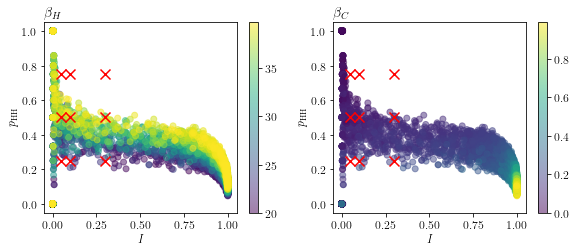

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_hh, ax = axs[0])

axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[0].set_title(r'$\beta_H$', loc = 'left')

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
plt.colorbar(plot_cc, ax = axs[1])

axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)
axs[1].set_title(r'$\beta_C$', loc = 'left')

plt.savefig('plots/prp_vs_inc_1.png', transparent = True, dpi = 300)

In [11]:
idx = (idcs >= 0.09) & (idcs <= 0.11) & (prps >= 0.2) & (prps <= 0.3)

In [12]:
hh[idx], cc[idx]

(array([23.8, 24. ]), array([0.22, 0.25]))

In [13]:
hh

array([[20. , 20. , 20. , ..., 20. , 20. , 20. ],
       [20.2, 20.2, 20.2, ..., 20.2, 20.2, 20.2],
       [20.4, 20.4, 20.4, ..., 20.4, 20.4, 20.4],
       ...,
       [39.4, 39.4, 39.4, ..., 39.4, 39.4, 39.4],
       [39.6, 39.6, 39.6, ..., 39.6, 39.6, 39.6],
       [39.8, 39.8, 39.8, ..., 39.8, 39.8, 39.8]])

In [14]:
cc

array([[0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       ...,
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99]])

In [11]:
results = SEIR(23.8, 0.22, num_weeks_inf, num_weeks_inc)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 

In [12]:
metrics(results)

(0.999, 0.22922922922922923)

## More Results

In [20]:
idcs = np.load('results/1/idcs.npy')
prps = np.load('results/1/prps.npy')

cc = np.load('results/1/cc.npy')
hh = np.load('results/1/hh.npy')

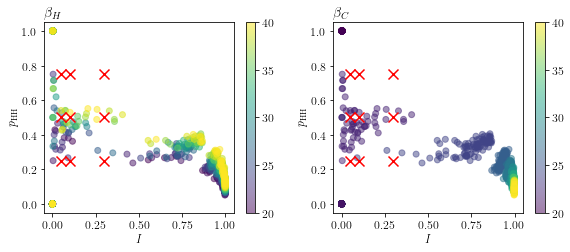

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (9.5, 3.5))

plot_hh = axs[0].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(hh.flatten(), 5), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(idcs.flatten(), prps.flatten(), 
                         c = np.repeat(cc.flatten(), 5), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('prp_vs_inc_2.png', transparent = True, dpi = 300)

# 14 February

Results for a $\beta_H$ grid of $[20, 20.8, 21.6, \ldots, 39.2, 40]$ and $\beta_C$ grid of $[0, 0.04, 0.08, \ldots, 0.96, 1]$.

In [2]:
idcs = np.load('results/2/idcs.npy')
prps = np.load('results/2/prps.npy')

cc = np.load('results/2/cc.npy')
hh = np.load('results/2/hh.npy')

In [3]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

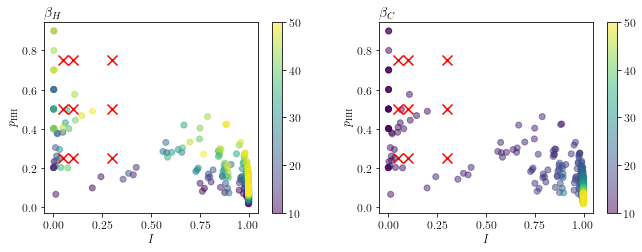

In [46]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)

axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_2.png', transparent = True, dpi = 300)

Results for a $\beta_H$ grid of $[10, 12, 14, \ldots, 48, 50]$ and $\beta_C$ grid of $[0, 0.1, 0.2, \ldots, 1.9, 2]$.

In [47]:
idcs = np.load('results/3/idcs_3.npy')
prps = np.load('results/3/prps_3.npy')

cc = np.load('results/3/cc_3.npy')
hh = np.load('results/3/hh_3.npy')

In [48]:
mean_idcs = idcs.mean(axis = 2)
mean_prps = prps.mean(axis = 2)

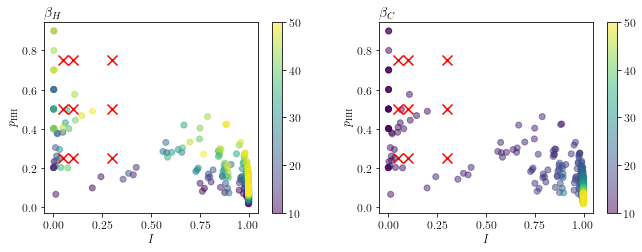

In [50]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3.5))

plot_hh = axs[0].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = hh.flatten(), alpha = 0.5)
axs[0].set_xlabel(r'$I$')
axs[0].set_ylabel(r'$p_{\rm HH}$')
axs[0].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[0])
axs[0].set_title(r'$\beta_H$', loc = 'left')
axs[0].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[0].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[0].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plot_cc = axs[1].scatter(mean_idcs.flatten(), mean_prps.flatten(), 
                         c = cc.flatten(), alpha = 0.5)
axs[1].set_xlabel(r'$I$')
axs[1].set_ylabel(r'$p_{\rm HH}$')
axs[1].set_aspect('equal')
fig.colorbar(plot_hh, ax = axs[1])
axs[1].set_title(r'$\beta_C$', loc = 'left')
axs[1].scatter(0.05, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.05, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.1, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.1, 0.75, marker = 'x', c = 'red', s = 100)

axs[1].scatter(0.3, 0.25, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.5, marker = 'x', c = 'red', s = 100)
axs[1].scatter(0.3, 0.75, marker = 'x', c = 'red', s = 100)

plt.savefig('plots/prp_vs_inc_3.png', transparent = True, dpi = 300)

# 15 February

In [84]:
idcs_1 = np.load('results/4/idcs_1.npy')
prps_1 = np.load('results/4/prps_1.npy')

idcs_2 = np.load('results/4/idcs_2.npy')
prps_2 = np.load('results/4/prps_2.npy')

idcs_3 = np.load('results/4/idcs_3.npy')
prps_3 = np.load('results/4/prps_3.npy')

beta_H_vals = [20.6, 30, 29.6]
beta_C_vals = [0.30, 0.12, 0.20]

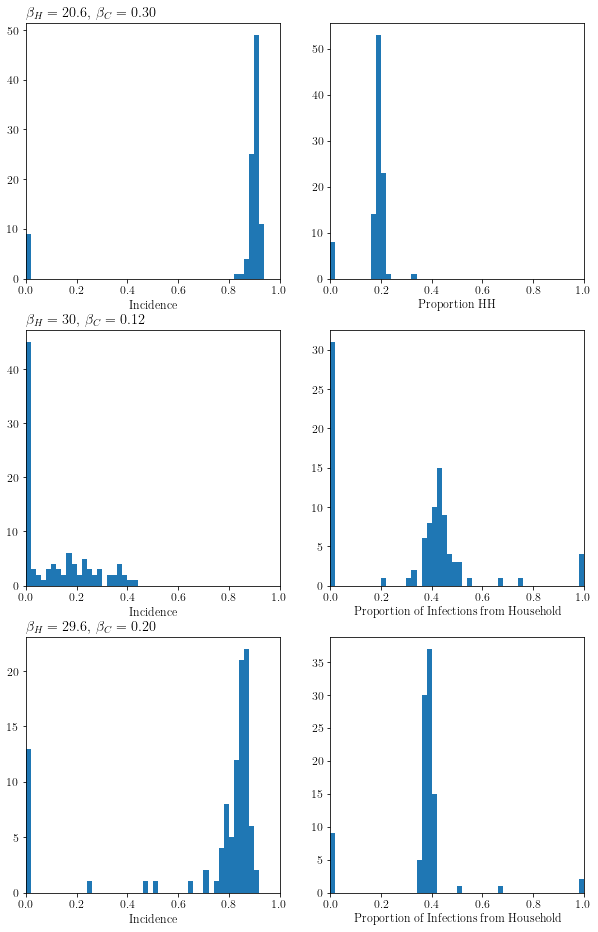

In [104]:
fig, axs = plt.subplots(3, 2, figsize = (10, 16))
bins = np.linspace(0, 1, 51)

axs[0][0].hist(idcs_1, bins = bins)
axs[0][1].hist(prps_1, bins = bins)
axs[0][0].set_xlim(0, 1)
axs[0][1].set_xlim(0, 1)
axs[0][0].set_title(r'$\beta_H = 20.6$, $\beta_C = 0.30$', loc = 'left')
axs[0][0].set_xlabel('Incidence')
axs[0][1].set_xlabel('Proportion HH')

axs[1][0].hist(idcs_2, bins = bins)
axs[1][1].hist(prps_2, bins = bins)
axs[1][0].set_xlim(0, 1)
axs[1][1].set_xlim(0, 1)
axs[1][0].set_title(r'$\beta_H = 30$, $\beta_C = 0.12$', loc = 'left')
axs[1][0].set_xlabel('Incidence')
axs[1][1].set_xlabel('Proportion of Infections from Household')

axs[2][0].hist(idcs_3, bins = bins)
axs[2][1].hist(prps_3, bins = bins)
axs[2][0].set_xlim(0, 1)
axs[2][1].set_xlim(0, 1)
axs[2][0].set_title(r'$\beta_H = 29.6$, $\beta_C = 0.20$', loc = 'left')
axs[2][0].set_xlabel('Incidence')
axs[2][1].set_xlabel('Proportion of Infections from Household')
plt.savefig('plots/param_check.png', transparent = False, dpi = 300)

In [101]:
idcs_1.mean(), prps_1.mean()

(0.82155, 0.17921383118483383)

In [102]:
idcs_2.mean(), prps_2.mean()

(0.11649, 0.3193671653722158)

In [103]:
idcs_3.mean(), prps_3.mean()

(0.7165500000000001, 0.365385049020263)

In [107]:
idcs_3[prps_3 == 1]

array([0.001, 0.001])

In [110]:
prps_1[idcs_1 == 0]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [111]:
prps_2[idcs_2 == 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [112]:
prps_3[idcs_3 == 0]

array([0., 0., 0., 0., 0., 0., 0.])